In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install --upgrade tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 34.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attemptin

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import metrics, Model, layers
from tensorflow.keras import layers, models, optimizers
from pathlib import Path
from PIL import Image

2024-04-14 17:34:56.519458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 17:34:56.519587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 17:34:56.632931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**DATASET**

In [2]:
from pathlib import Path
import os
import cv2

# Set the data directory path
data_dir = '/kaggle/input/cellimagesfordetectingmalaria/cell_images'

# Create the paths for parasitized and uninfected images
parasitized_data = list(Path(os.path.join(data_dir, 'Parasitized')).rglob('*.png'))
uninfected_data = list(Path(os.path.join(data_dir, 'Uninfected')).rglob('*.png'))

data = []
labels = []
IMG_SIZE = 130

In [3]:
for img_path in parasitized_data:
    try:
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_array = np.array(img)
        data.append(img_array)
        labels.append(1)
    except Exception as e:
        print(f"Error loading parasitized image {img_path}: {e}")

# Load uninfected images
for img_path in uninfected_data:
    try:
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_array = np.array(img)
        data.append(img_array)
        labels.append(0)
    except Exception as e:
        print(f"Error loading uninfected image {img_path}: {e}")

image_data = np.array(data)
labels = np.array(labels)

print("image_data shape:", image_data.shape)
print("labels shape:", labels.shape)

image_data shape: (27558, 130, 130, 3)
labels shape: (27558,)


**VISUALIZATION**

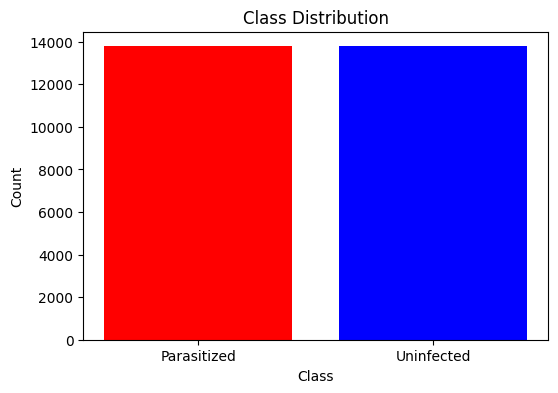

In [6]:
import matplotlib.pyplot as plt

# Class Distribution Bar Plot
plt.figure(figsize=(6, 4))
plt.bar(['Parasitized', 'Uninfected'], [np.sum(labels==1), np.sum(labels==0)], color=['red', 'blue'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()




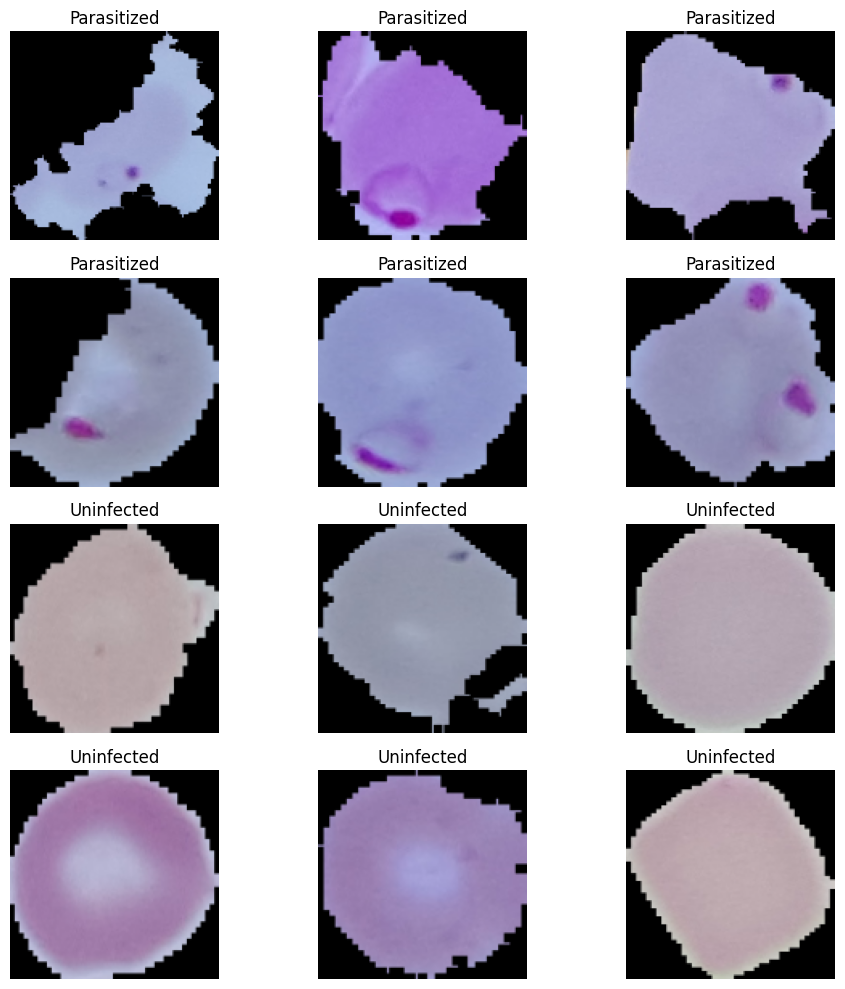

In [5]:
import matplotlib.pyplot as plt
import random
num_images = 12
num_rows = 4
num_cols = 3
# Get random indices for each class
parasitized_indices = np.where(labels == 1)[0]
uninfected_indices = np.where(labels == 0)[0]
# Choose random indices from each class
random_parasitized_indices = random.sample(list(parasitized_indices), num_images // 2)
random_uninfected_indices = random.sample(list(uninfected_indices), num_images // 2)
# Plot random images
plt.figure(figsize=(10, 10))
# Plot parasitized images
for i, idx in enumerate(random_parasitized_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image_data[idx])
    plt.title('Parasitized')
    plt.axis('off')
# Plot uninfected images
for i, idx in enumerate(random_uninfected_indices):
    plt.subplot(num_rows, num_cols, i + num_images // 2 + 1)
    plt.imshow(image_data[idx])
    plt.title('Uninfected')
    plt.axis('off')
plt.tight_layout()
plt.show()

**TEST-TRAIN SPLIT**

In [7]:
from sklearn.model_selection import train_test_split

# Shuffle the indices of the dataset
#indices = np.arange(len(image_data))
#np.random.shuffle(indices)

# Use the shuffled indices to shuffle the dataset
#shuffled_image_data = image_data[indices]
#shuffled_labels = labels[indices]

# Split the shuffled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=0)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)


**AUGMENTATION**

In [8]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
    

In [9]:
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=32)

**CLASS DISTRIBUTION VISUALIZATION**

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of parasitized and uninfected samples in training and testing sets
train_parasitized_count = np.sum(y_train[:, 1])
train_uninfected_count = np.sum(y_train[:, 0])
test_parasitized_count = np.sum(y_test[:, 1])
test_uninfected_count = np.sum(y_test[:, 0])

# Plot the counts in two different graphs
plt.figure(figsize=(10, 5))

# Plot training set counts
plt.subplot(1, 2, 1)
plt.bar(['Parasitized', 'Uninfected'], [train_parasitized_count, train_uninfected_count], color=['red', 'blue'])
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Plot testing set counts
plt.subplot(1, 2, 2)
plt.bar(['Parasitized', 'Uninfected'], [test_parasitized_count, test_uninfected_count], color=['red', 'blue'])
plt.title('Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


**VGG16**

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense

# Instantiating the VGG16 model
vgg16 = VGG16(
    input_shape=[IMG_SIZE, IMG_SIZE] + [3],
    weights='imagenet',  # Include the pre-trained weights on ImageNet
    include_top=False
)

for layer in vgg16.layers:
    layer.trainable = False

# Defining input and output to the model
x = Flatten()(vgg16.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
prediction = Dense(2, activation='softmax')(x)

# Creating a new model with our custom top layers
model_vgg16 = Model(inputs=vgg16.input, outputs=prediction)

# Print model summary
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 130, 130, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 130, 130, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 130, 130, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 65, 65, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 65, 65, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,19

 Total params: 65,062,722 (248.19 MB)

 Trainable params: 50,348,034 (192.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

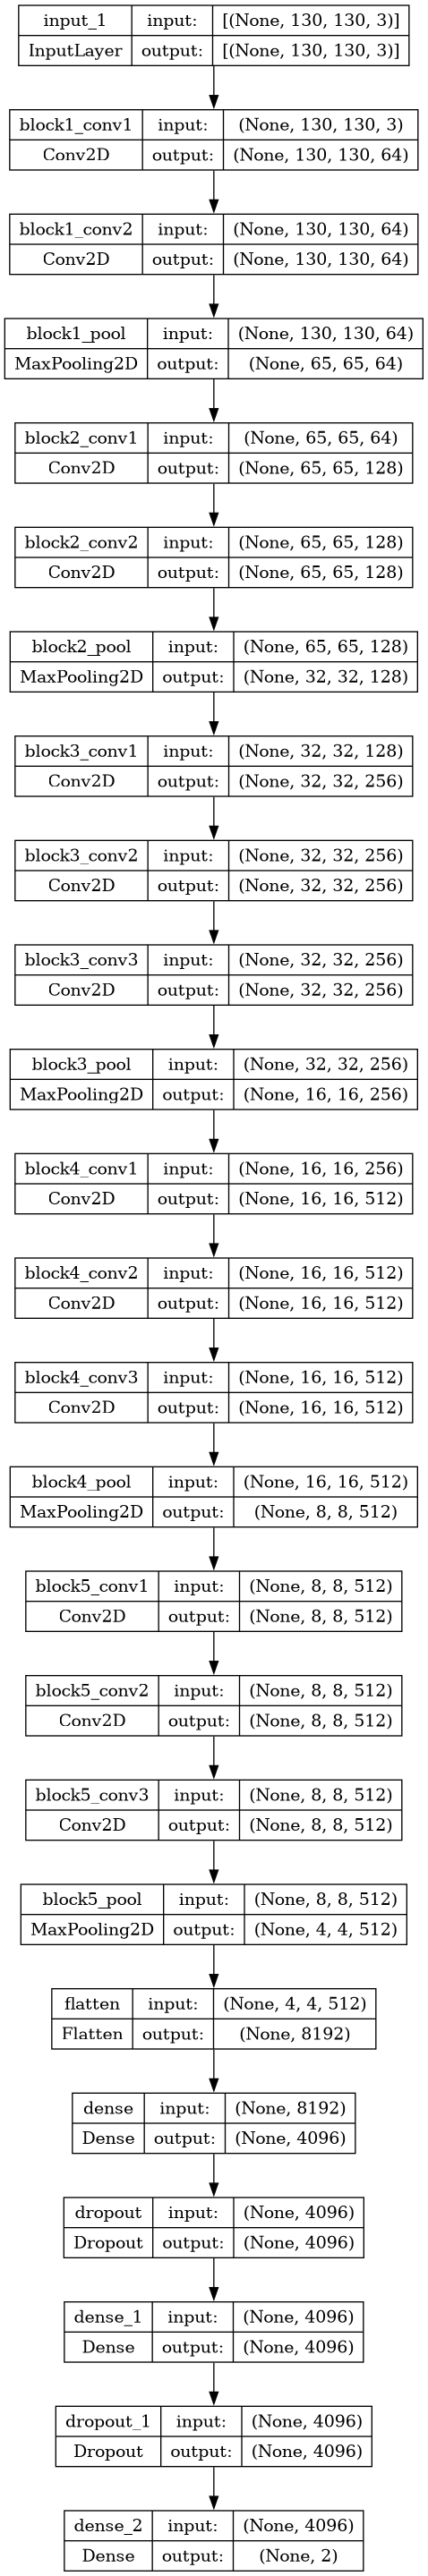

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model_vgg16, to_file='model_summary.png', show_shapes=True, show_layer_names=True)


In [9]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00001)
model_vgg16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
vgg16_10 = model_vgg16.fit(train_generator, epochs=10, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/689 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - accuracy: 0.4219 - loss: 0.9942  

W0000 00:00:1713112149.954210      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6536 - loss: 0.6651

W0000 00:00:1713112274.705092      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 141s 195ms/step - accuracy: 0.6537 - loss: 0.6649 - val_accuracy: 0.8734 - val_loss: 0.2962
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 115s 165ms/step - accuracy: 0.8203 - loss: 0.4041 - val_accuracy: 0.9002 - val_loss: 0.2469
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 115s 165ms/step - accuracy: 0.8510 - loss: 0.3545 - val_accuracy: 0.8962 - val_loss: 0.2475
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 115s 165ms/step - accuracy: 0.8639 - loss: 0.3174 - val_accuracy: 0.9205 - val_loss: 0.2173
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 115s 165ms/step - accuracy: 0.8742 - loss: 0.3077 - val_accuracy: 0.9231 - val_loss: 0.2068
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 114s 164ms/step - accuracy: 0.8824 - loss: 0.2947 - val_accuracy: 0.9147 - val_loss: 0.2184
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 115s 165ms/step - accuracy: 0.8802 - loss: 0.2910 - val_accuracy: 0.9165 - val_loss: 0.2134
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 115s 165ms/step - accuracy: 0.8860 - loss: 0.28

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [19]:
y_pred_vgg16 = model_vgg16.predict(X_test)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step


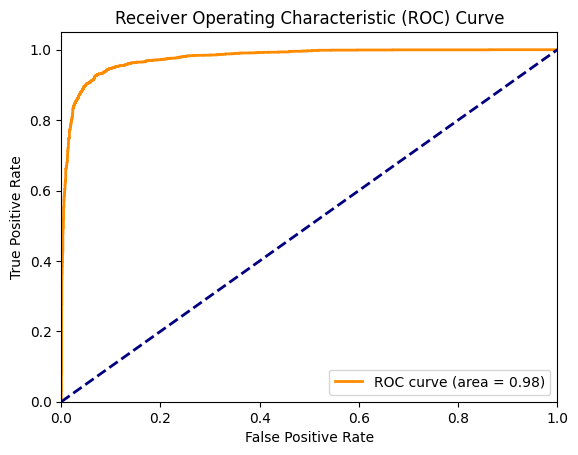

In [20]:

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred_vgg16[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

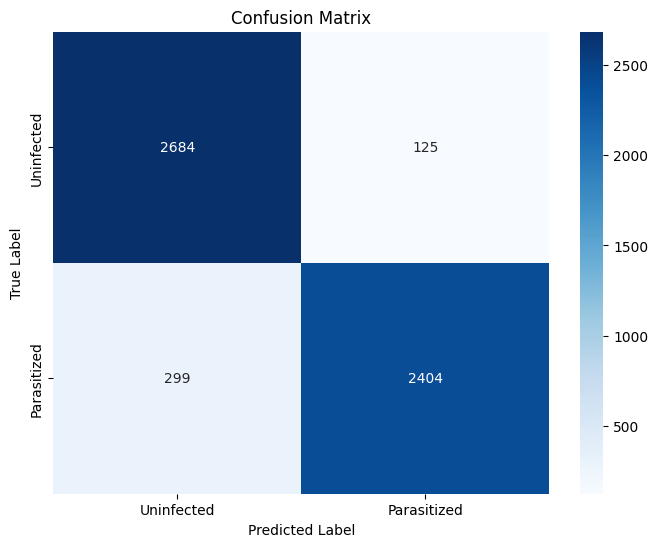

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes on the test set
y_pred_vgg16_1 = np.argmax(y_pred_vgg16, axis=1)
y_true_vgg16 = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_vgg16, y_pred_vgg16_1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Uninfected', 'Parasitized'], 
            yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [24]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true_vgg16, y_pred_vgg16_1, target_names=['Uninfected', 'Parasitized'])

# Print classification report
print(report)


              precision    recall  f1-score   support

  Uninfected       0.90      0.96      0.93      2809
 Parasitized       0.95      0.89      0.92      2703

    accuracy                           0.92      5512
   macro avg       0.93      0.92      0.92      5512
weighted avg       0.92      0.92      0.92      5512



In [ ]:
# Evaluate training accuracy
train_loss, train_accuracy = model_vgg16.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy:", train_accuracy)

# Evaluate testing accuracy
test_loss, test_accuracy = model_vgg16.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy:", test_accuracy)


**VGG19**

In [10]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

# To avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense

# Instantiating the VGG16 model
vgg19 = VGG19(
    input_shape=[IMG_SIZE, IMG_SIZE] + [3],
    weights='imagenet',  # Include the pre-trained weights on ImageNet
    include_top=False
)

for layer in vgg19.layers:
    layer.trainable = False

# Defining input and output to the model
x = Flatten()(vgg19.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
prediction = Dense(2, activation='softmax')(x)

# Creating a new model with our custom top layers
model_vgg19 = Model(inputs=vgg19.input, outputs=prediction)

# Print model summary
model_vgg19.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 130, 130, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 130, 130, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 130, 130, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 65, 65, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 65, 65, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             

 Total params: 70,372,418 (268.45 MB)

 Trainable params: 50,348,034 (192.06 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [12]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00001)
model_vgg19.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
vgg19_10 = model_vgg19.fit(train_generator, epochs=10, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/10
  2/689 ━━━━━━━━━━━━━━━━━━━━ 1:02 91ms/step - accuracy: 0.3750 - loss: 1.4212  

I0000 00:00:1713116498.554832      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713116498.575088      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6239 - loss: 0.7185

W0000 00:00:1713116612.357025      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 147s 187ms/step - accuracy: 0.6240 - loss: 0.7183 - val_accuracy: 0.8543 - val_loss: 0.3411
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 151ms/step - accuracy: 0.8076 - loss: 0.4239 - val_accuracy: 0.8608 - val_loss: 0.3200
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 106s 152ms/step - accuracy: 0.8376 - loss: 0.3690 - val_accuracy: 0.8757 - val_loss: 0.2880
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 106s 152ms/step - accuracy: 0.8524 - loss: 0.3475 - val_accuracy: 0.8755 - val_loss: 0.2865
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 151ms/step - accuracy: 0.8601 - loss: 0.3334 - val_accuracy: 0.8657 - val_loss: 0.3033
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 151ms/step - accuracy: 0.8703 - loss: 0.3182 - val_accuracy: 0.8922 - val_loss: 0.2607
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 151ms/step - accuracy: 0.8716 - loss: 0.3123 - val_accuracy: 0.8596 - val_loss: 0.3139
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 151ms/step - accuracy: 0.8732 - loss: 0.30

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [16]:
y_pred_vgg19 = model_vgg19.predict(X_test)

  3/173 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step

W0000 00:00:1713117584.524388      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step


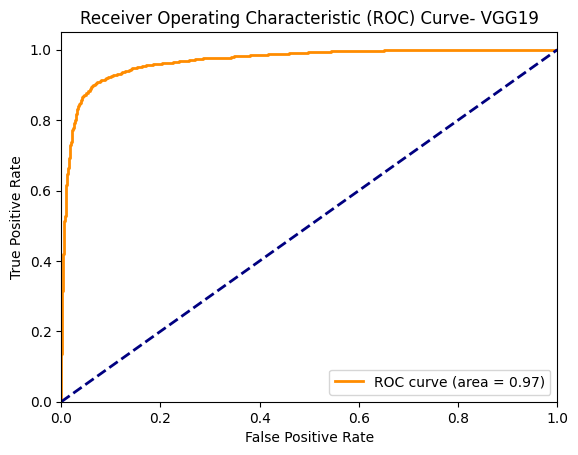

In [17]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred_vgg19[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- VGG19')
plt.legend(loc="lower right")
plt.show()

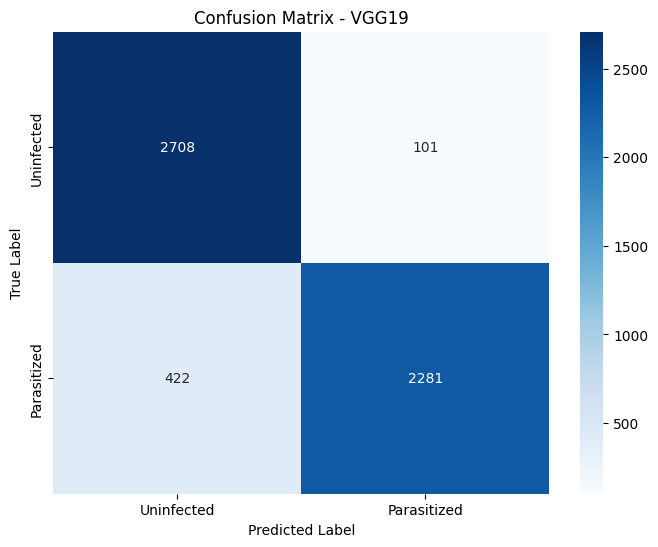

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes on the test set
y_pred_vgg19_1 = np.argmax(y_pred_vgg19, axis=1)
y_true_vgg19 = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_vgg19, y_pred_vgg19_1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Uninfected', 'Parasitized'], 
            yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix - VGG19')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true_vgg19, y_pred_vgg19_1, target_names=['Uninfected', 'Parasitized'])

# Print classification report
print(report)

              precision    recall  f1-score   support

  Uninfected       0.87      0.96      0.91      2809
 Parasitized       0.96      0.84      0.90      2703

    accuracy                           0.91      5512
   macro avg       0.91      0.90      0.90      5512
weighted avg       0.91      0.91      0.90      5512



RESNET18

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [22]:
# Basic Block for ResNet
def basic_block(input_tensor, filters, stride=1):
    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = input_tensor
    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    x = Activation('relu')(x + shortcut)
    return x

In [23]:
def ResNet18(input_shape=(130, 130, 3), num_classes=2):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Stack of Basic Blocks
    x = basic_block(x, filters=64, stride=1)
    x = basic_block(x, filters=64, stride=1)

    x = basic_block(x, filters=128, stride=2)
    x = basic_block(x, filters=128, stride=1)

    x = basic_block(x, filters=256, stride=2)
    x = basic_block(x, filters=256, stride=1)

    x = basic_block(x, filters=512, stride=2)
    x = basic_block(x, filters=512, stride=1)

    # Global Average Pooling
    x = AveragePooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    prediction = Dense(num_classes, activation='softmax')(x)
    model_resnet18 = Model(inputs=input_tensor, outputs=prediction, name='resnet18')
    return model_resnet18

# Creating an instance of ResNet-18
model_resnet18 = ResNet18()

# Printing the model summary
model_resnet18.summary()

Model: "resnet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 130, 130,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 65, 65,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 65, 65,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 65, 65,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 33, 33,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 33, 33,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 33, 33,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 33, 33,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 33, 33,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 33, 33,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 33, 33,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 33, 33,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        256 │ conv2d_4[0][0]  

 Total params: 19,591,810 (74.74 MB)

 Trainable params: 19,582,210 (74.70 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [24]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00001)
model_resnet18.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
resnet18_10 = model_resnet18.fit(train_generator, epochs=10, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/10
  2/689 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 0.4688 - loss: 1.0010   

W0000 00:00:1713117713.039447      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5939 - loss: 0.7545

W0000 00:00:1713117828.139400      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 148s 175ms/step - accuracy: 0.5939 - loss: 0.7544 - val_accuracy: 0.7373 - val_loss: 0.5251
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 100s 143ms/step - accuracy: 0.7558 - loss: 0.5102 - val_accuracy: 0.8175 - val_loss: 0.4238
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 100s 143ms/step - accuracy: 0.8433 - loss: 0.3702 - val_accuracy: 0.9051 - val_loss: 0.2391
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 143ms/step - accuracy: 0.8760 - loss: 0.3075 - val_accuracy: 0.6440 - val_loss: 0.7424
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 100s 144ms/step - accuracy: 0.8933 - loss: 0.2689 - val_accuracy: 0.9258 - val_loss: 0.2069
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 100s 143ms/step - accuracy: 0.9058 - loss: 0.2443 - val_accuracy: 0.9189 - val_loss: 0.2330
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 100s 144ms/step - accuracy: 0.9144 - loss: 0.2287 - val_accuracy: 0.9443 - val_loss: 0.1623
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 101s 144ms/step - accuracy: 0.9189 - loss: 0.218

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [27]:
y_pred_resnet18 = model_resnet18.predict(X_test)

  8/173 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step

W0000 00:00:1713118763.142284      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step


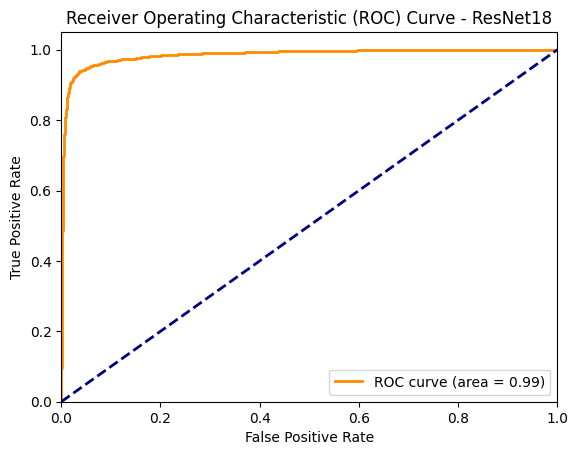

In [28]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred_resnet18[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - ResNet18')
plt.legend(loc="lower right")
plt.show()

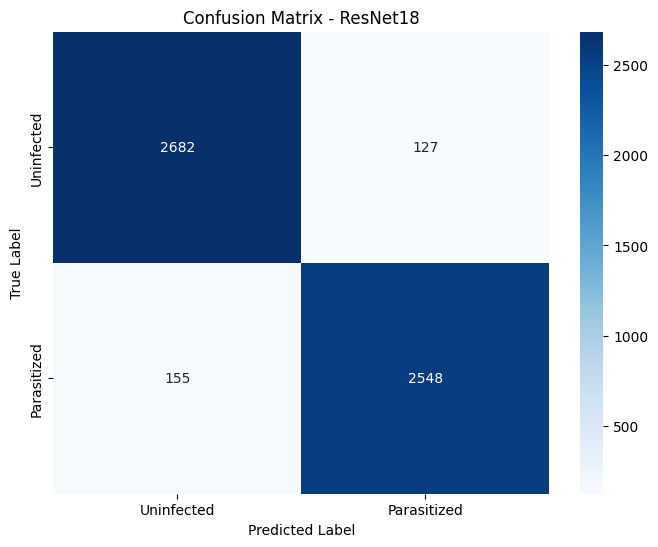

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes on the test set
y_pred_resnet18_1 = np.argmax(y_pred_resnet18, axis=1)
y_true_resnet18 = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_resnet18, y_pred_resnet18_1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Uninfected', 'Parasitized'], 
            yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix - ResNet18')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [30]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true_resnet18, y_pred_resnet18_1, target_names=['Uninfected', 'Parasitized'])

# Print classification report
print(report)

              precision    recall  f1-score   support

  Uninfected       0.95      0.95      0.95      2809
 Parasitized       0.95      0.94      0.95      2703

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512

